# Freddie Mac Survival Analysis - Data Exploration

This notebook explores the preprocessed survival analysis data from Freddie Mac Single Family Loans.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

sns.set_style('whitegrid')
%matplotlib inline

## Load Data

In [2]:
# Load the preprocessed survival data
# Try parquet first (faster), fall back to CSV if pyarrow not installed
try:
    df = pd.read_parquet('../data/processed/survival_data.parquet')
except ImportError:
    df = pd.read_csv('../data/processed/survival_data.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1324950, 35)


,loan_sequence_number,duration,event,event_type,vintage_year,credit_score,orig_ltv,orig_cltv,orig_dti,orig_upb,...,fico_band,ltv_band,dti_band,occupancy_status_desc,loan_purpose_desc,property_type_desc,channel_desc,loan_term_years,mi_pct,max_delinquency
0,F99Q10000029,20,1,prepay,1999,618,85,85,24,122000,...,<620,81-90,21-30,primary_residence,no_cash_out_refi,single_family,retail,26.416667,25,0
1,F99Q10000064,125,1,prepay,1999,619,74,74,25,107000,...,<620,71-80,21-30,primary_residence,no_cash_out_refi,single_family,retail,15.000000,0,0
2,F99Q10000070,26,1,prepay,1999,515,78,78,32,232000,...,<620,71-80,31-40,second_home,purchase,single_family,retail,26.083333,0,0
3,F99Q10000170,40,1,default,1999,649,95,95,46,157000,...,620-679,91-95,41-50,primary_residence,purchase,single_family,tpo_not_specified,30.000000,<NA>,99
4,F99Q10000228,32,1,prepay,1999,768,75,75,21,111000,...,740-779,71-80,21-30,primary_residence,cash_out_refi,single_family,retail,30.000000,0,0


In [3]:
# Basic statistics
print("=== Event Distribution ===")
print(df['event_type'].value_counts())
print(f"\nCensoring rate: {(df['event'] == 0).mean():.2%}")

=== Event Distribution ===
event_type
prepay      941535
censored    345972
default      19728
matured       7113
other         7016
defect        3586
Name: count, dtype: int64

Censoring rate: 26.11%


## Summary Statistics by Vintage

Explore key metrics per vintage year to understand how loan characteristics and outcomes vary over time.

In [4]:
# Summary statistics by vintage year
vintage_stats = df.groupby('vintage_year').agg({
    'loan_sequence_number': 'count',
    'duration': ['mean', 'median'],
    'event': 'mean',
    'credit_score': 'mean',
    'orig_ltv': 'mean',
    'orig_dti': 'mean',
    'orig_interest_rate': 'mean',
    'orig_upb': 'mean',
}).round(2)

# Flatten column names
vintage_stats.columns = ['_'.join(col).strip() for col in vintage_stats.columns]
vintage_stats = vintage_stats.rename(columns={
    'loan_sequence_number_count': 'n_loans',
    'duration_mean': 'avg_duration',
    'duration_median': 'median_duration',
    'event_mean': 'event_rate',
    'credit_score_mean': 'avg_fico',
    'orig_ltv_mean': 'avg_ltv',
    'orig_dti_mean': 'avg_dti',
    'orig_interest_rate_mean': 'avg_rate',
    'orig_upb_mean': 'avg_upb',
})

# Add event type breakdown
event_breakdown = df.groupby(['vintage_year', 'event_type']).size().unstack(fill_value=0)
event_breakdown_pct = event_breakdown.div(event_breakdown.sum(axis=1), axis=0) * 100

vintage_stats['default_pct'] = event_breakdown_pct.get('default', 0).round(2)
vintage_stats['prepay_pct'] = event_breakdown_pct.get('prepay', 0).round(2)
vintage_stats['matured_pct'] = event_breakdown_pct.get('matured', 0).round(2)
vintage_stats['censored_pct'] = event_breakdown_pct.get('censored', 0).round(2)

print("=== Summary Statistics by Vintage Year ===\n")
display(vintage_stats)

=== Summary Statistics by Vintage Year ===



,n_loans,avg_duration,median_duration,event_rate,avg_fico,avg_ltv,avg_dti,avg_rate,avg_upb,default_pct,prepay_pct,matured_pct,censored_pct
vintage_year,,,,,,,,,,,,,
1999,50000,50.89,41.0,1.00,715.86,71.1,31.66,7.34,115999.54,0.93,97.27,1.03,0.38
2000,50000,28.46,20.0,1.00,715.77,72.54,33.4,8.13,123682.88,1.29,97.65,0.34,0.24
2001,50000,38.82,23.0,1.00,719.6,70.35,31.9,6.86,136940.06,1.18,97.13,0.86,0.41
2002,50000,49.01,24.0,0.99,723.6,68.27,31.96,6.39,142358.58,1.29,95.94,1.64,0.65
2003,50000,80.56,76.0,0.98,731.85,66.11,30.6,5.51,144270.92,1.39,93.26,3.30,1.53
2004,50000,78.13,72.0,0.98,722.91,69.16,33.51,5.66,154524.16,2.90,91.68,2.19,2.16
2005,50000,75.01,67.0,0.97,724.97,68.84,35.2,5.80,169660.06,5.38,89.12,1.01,2.60
2006,50000,61.00,50.0,0.98,723.56,69.96,36.52,6.40,178786.78,7.66,86.70,0.46,2.37
2007,50000,56.83,46.0,0.97,725.24,71.31,36.62,6.37,182570.3,8.51,84.67,0.33,2.83


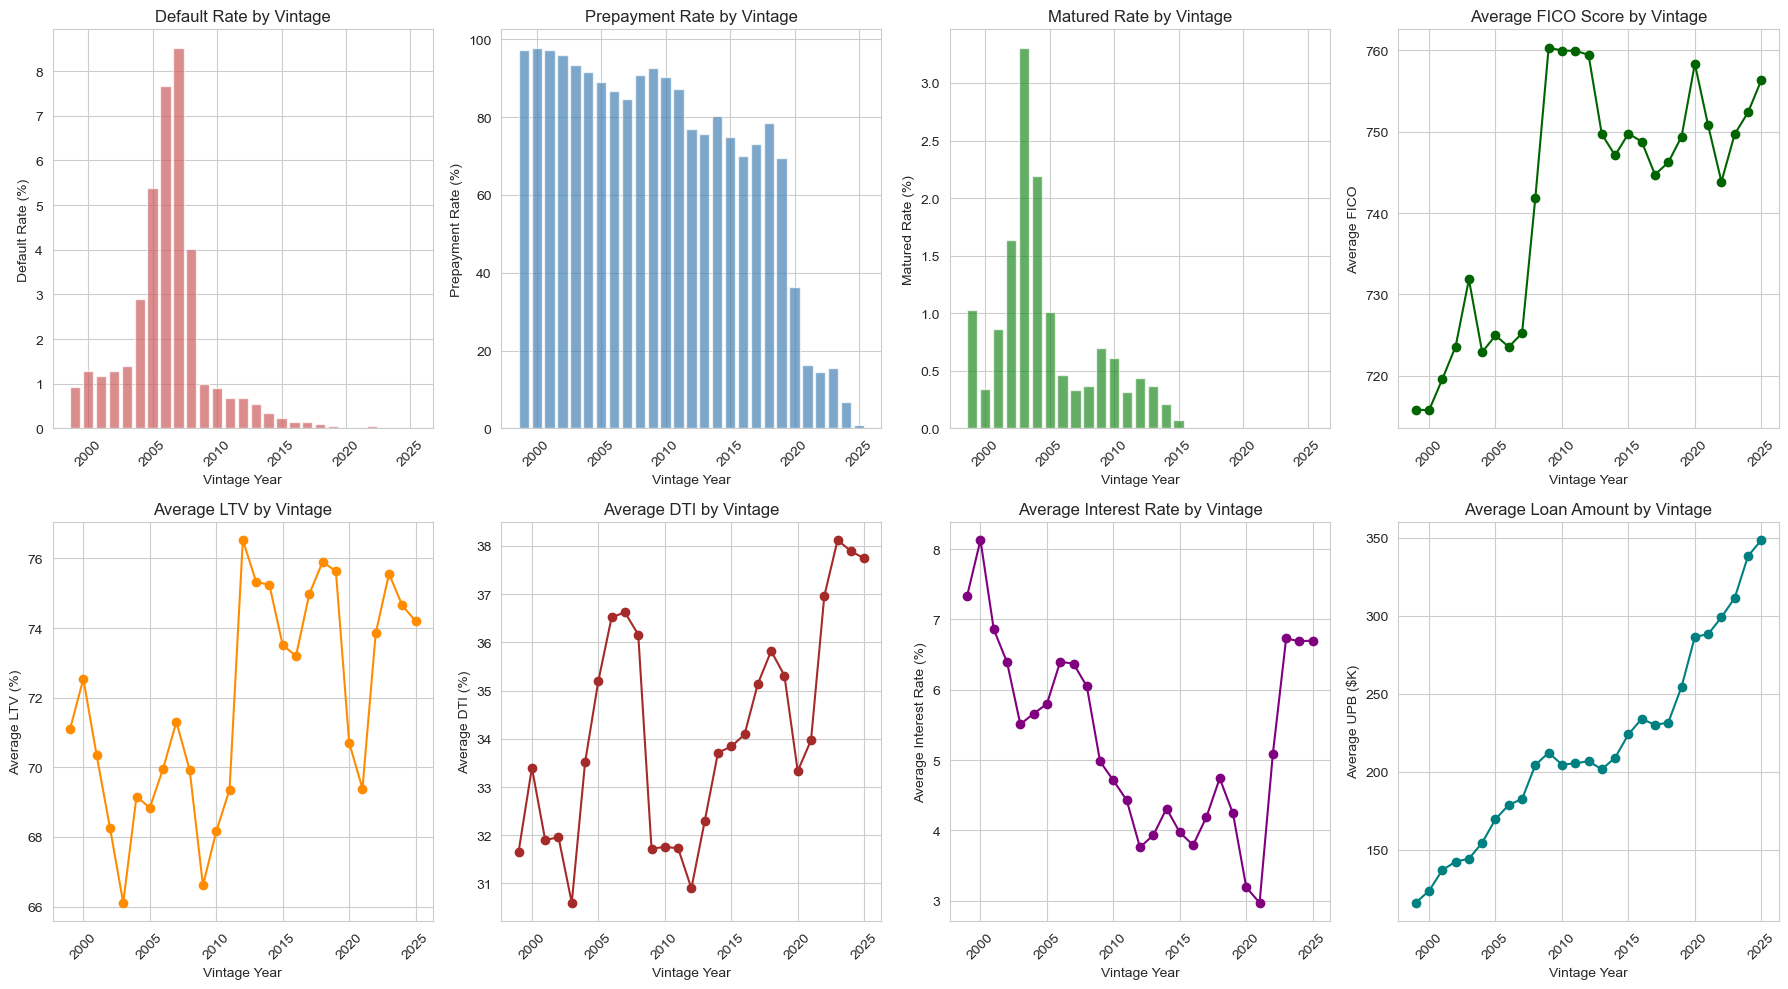

In [5]:
# Visualize key metrics by vintage
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

vintages = vintage_stats.index

# Default rate over time
axes[0, 0].bar(vintages, vintage_stats['default_pct'], color='indianred', alpha=0.7)
axes[0, 0].set_xlabel('Vintage Year')
axes[0, 0].set_ylabel('Default Rate (%)')
axes[0, 0].set_title('Default Rate by Vintage')
axes[0, 0].tick_params(axis='x', rotation=45)

# Prepayment rate over time
axes[0, 1].bar(vintages, vintage_stats['prepay_pct'], color='steelblue', alpha=0.7)
axes[0, 1].set_xlabel('Vintage Year')
axes[0, 1].set_ylabel('Prepayment Rate (%)')
axes[0, 1].set_title('Prepayment Rate by Vintage')
axes[0, 1].tick_params(axis='x', rotation=45)

# Matured rate over time
axes[0, 2].bar(vintages, vintage_stats['matured_pct'], color='forestgreen', alpha=0.7)
axes[0, 2].set_xlabel('Vintage Year')
axes[0, 2].set_ylabel('Matured Rate (%)')
axes[0, 2].set_title('Matured Rate by Vintage')
axes[0, 2].tick_params(axis='x', rotation=45)

# Average FICO over time
axes[0, 3].plot(vintages, vintage_stats['avg_fico'], marker='o', color='darkgreen')
axes[0, 3].set_xlabel('Vintage Year')
axes[0, 3].set_ylabel('Average FICO')
axes[0, 3].set_title('Average FICO Score by Vintage')
axes[0, 3].tick_params(axis='x', rotation=45)

# Average LTV over time
axes[1, 0].plot(vintages, vintage_stats['avg_ltv'], marker='o', color='darkorange')
axes[1, 0].set_xlabel('Vintage Year')
axes[1, 0].set_ylabel('Average LTV (%)')
axes[1, 0].set_title('Average LTV by Vintage')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average DTI over time
axes[1, 1].plot(vintages, vintage_stats['avg_dti'], marker='o', color='brown')
axes[1, 1].set_xlabel('Vintage Year')
axes[1, 1].set_ylabel('Average DTI (%)')
axes[1, 1].set_title('Average DTI by Vintage')
axes[1, 1].tick_params(axis='x', rotation=45)

# Average interest rate over time
axes[1, 2].plot(vintages, vintage_stats['avg_rate'], marker='o', color='purple')
axes[1, 2].set_xlabel('Vintage Year')
axes[1, 2].set_ylabel('Average Interest Rate (%)')
axes[1, 2].set_title('Average Interest Rate by Vintage')
axes[1, 2].tick_params(axis='x', rotation=45)

# Average loan amount over time
axes[1, 3].plot(vintages, vintage_stats['avg_upb'] / 1000, marker='o', color='teal')
axes[1, 3].set_xlabel('Vintage Year')
axes[1, 3].set_ylabel('Average UPB ($K)')
axes[1, 3].set_title('Average Loan Amount by Vintage')
axes[1, 3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/vintage_trends.png', dpi=150)
plt.show()

## Duration Distribution

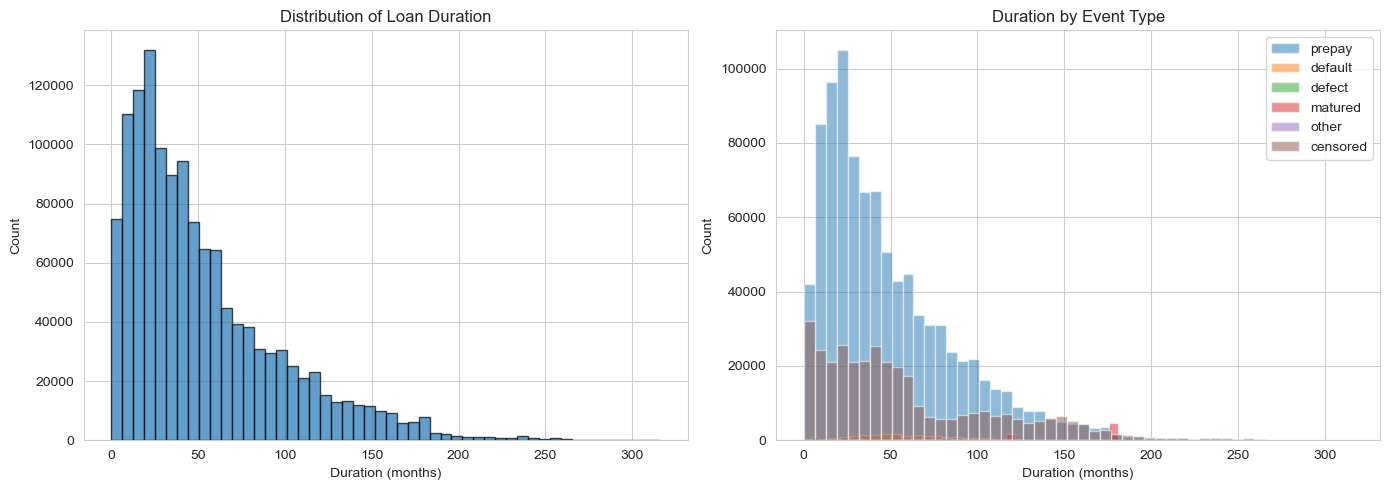

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall duration distribution
axes[0].hist(df['duration'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Duration (months)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Loan Duration')

# Duration by event type
for event_type in df['event_type'].unique():
    subset = df[df['event_type'] == event_type]['duration']
    axes[1].hist(subset, bins=50, alpha=0.5, label=event_type)
axes[1].set_xlabel('Duration (months)')
axes[1].set_ylabel('Count')
axes[1].set_title('Duration by Event Type')
axes[1].legend()

plt.tight_layout()
plt.show()

## Kaplan-Meier Survival Curves

Median survival time: 51.0 months

Survival probabilities:
  At  12 months: 90.0%
  At  24 months: 74.8%
  At  36 months: 62.2%
  At  60 months: 43.2%
  At 120 months: 16.6%


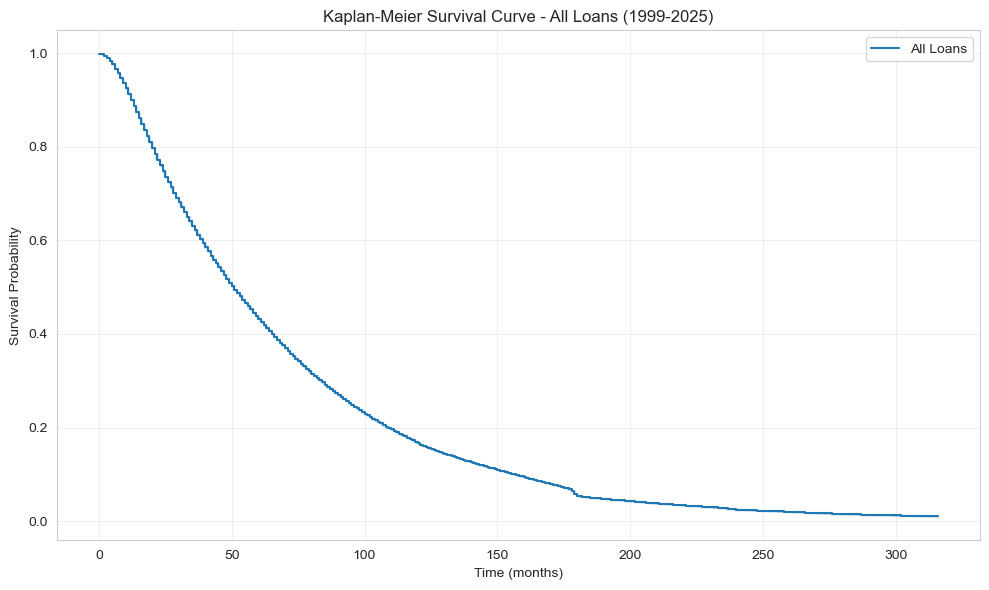

In [7]:
# Overall Kaplan-Meier survival curve
kmf = KaplanMeierFitter()
kmf.fit(df['duration'], event_observed=df['event'], label='All Loans')

# Print key statistics
print(f"Median survival time: {kmf.median_survival_time_:.1f} months")
print(f"\nSurvival probabilities:")
for t in [12, 24, 36, 60, 120]:
    if t <= df['duration'].max():
        surv_prob = kmf.predict(t)
        print(f"  At {t:3d} months: {surv_prob:.1%}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
kmf.plot_survival_function(ax=ax)
ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival Probability')
ax.set_title('Kaplan-Meier Survival Curve - All Loans (1999-2025)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/km_overall.png', dpi=150)
plt.show()

In [ ]:
# Survival curves by Vintage Year
fig, ax = plt.subplots(figsize=(12, 7))
vintage_groups = [(1999, 2005), (2006, 2008), (2009, 2015), (2016, 2020), (2021, 2025)]

for start, end in vintage_groups:
    mask = (df['vintage_year'] >= start) & (df['vintage_year'] <= end)
    if mask.sum() > 0:
        kmf_group = KaplanMeierFitter()
        kmf_group.fit(df.loc[mask, 'duration'], 
                      event_observed=df.loc[mask, 'event'], 
                      label=f'{start}-{end}')
        kmf_group.plot_survival_function(ax=ax)

ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival Probability')
ax.set_title('Kaplan-Meier Survival Curves by Vintage Year')
ax.legend(title='Vintage')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/km_by_vintage.png', dpi=150)
plt.show()

In [ ]:
# Survival curves by FICO Score bands
fig, ax = plt.subplots(figsize=(12, 7))
fico_bands = ['<620', '620-679', '680-739', '740-779', '780+']

for band in fico_bands:
    mask = df['fico_band'] == band
    if mask.sum() > 100:
        kmf_fico = KaplanMeierFitter()
        kmf_fico.fit(df.loc[mask, 'duration'], 
                     event_observed=df.loc[mask, 'event'], 
                     label=f'FICO {band}')
        kmf_fico.plot_survival_function(ax=ax)

ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival Probability')
ax.set_title('Kaplan-Meier Survival Curves by FICO Score')
ax.legend(title='FICO Band')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/km_by_fico.png', dpi=150)
plt.show()

In [ ]:
# Survival curves by LTV bands
fig, ax = plt.subplots(figsize=(12, 7))
ltv_bands = ['<=60', '61-70', '71-80', '81-90', '91-95', '>95']

for band in ltv_bands:
    mask = df['ltv_band'] == band
    if mask.sum() > 100:
        kmf_ltv = KaplanMeierFitter()
        kmf_ltv.fit(df.loc[mask, 'duration'], 
                    event_observed=df.loc[mask, 'event'], 
                    label=f'LTV {band}')
        kmf_ltv.plot_survival_function(ax=ax)

ax.set_xlabel('Time (months)')
ax.set_ylabel('Survival Probability')
ax.set_title('Kaplan-Meier Survival Curves by LTV')
ax.legend(title='LTV Band')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/km_by_ltv.png', dpi=150)
plt.show()

## Cox Proportional Hazards Model

In [ ]:
# Prepare data for Cox model
cox_cols = ['duration', 'event', 'credit_score', 'orig_ltv', 'orig_dti', 'orig_interest_rate']
cox_df = df[cox_cols].dropna()

# Rename columns for cleaner output
cox_df = cox_df.rename(columns={
    'credit_score': 'FICO',
    'orig_ltv': 'LTV',
    'orig_dti': 'DTI',
    'orig_interest_rate': 'Interest_Rate'
})

print(f"Data for Cox model: {len(cox_df):,} loans")

In [ ]:
# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='duration', event_col='event')

# Print summary
cph.print_summary()

In [ ]:
# Plot hazard ratios
fig, ax = plt.subplots(figsize=(10, 6))
cph.plot(ax=ax)
ax.set_title('Cox Proportional Hazards Model - Coefficient Plot')
plt.tight_layout()
plt.savefig('../reports/figures/cox_hazard_ratios.png', dpi=150)
plt.show()

## Competing Risks Analysis

Separate analysis for default vs prepayment events.

**Note:** Matured loans (`event_type='matured'`) are treated as censored (`event=0`) because maturity is deterministic and represents successful loan completion.

In [ ]:
# Competing Risks: Cause-specific survival curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Default-specific survival (treating prepay as censored)
df_default = df[df['event_type'].isin(['default', 'censored'])].copy()
df_default['event'] = (df_default['event_type'] == 'default').astype(int)
kmf_default = KaplanMeierFitter()
kmf_default.fit(df_default['duration'], event_observed=df_default['event'], label='Default')
kmf_default.plot_survival_function(ax=axes[0])
axes[0].set_xlabel('Time (months)')
axes[0].set_ylabel('Survival Probability (no default)')
axes[0].set_title('Cause-Specific Survival: Default')
axes[0].grid(True, alpha=0.3)

# Prepayment-specific survival (treating default as censored)
df_prepay = df[df['event_type'].isin(['prepay', 'censored'])].copy()
df_prepay['event'] = (df_prepay['event_type'] == 'prepay').astype(int)
kmf_prepay = KaplanMeierFitter()
kmf_prepay.fit(df_prepay['duration'], event_observed=df_prepay['event'], label='Prepayment')
kmf_prepay.plot_survival_function(ax=axes[1])
axes[1].set_xlabel('Time (months)')
axes[1].set_ylabel('Survival Probability (no prepay)')
axes[1].set_title('Cause-Specific Survival: Prepayment')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/km_competing_risks.png', dpi=150)
plt.show()

print(f"Default events: {df_default['event'].sum():,} ({df_default['event'].mean():.2%})")
print(f"Prepayment events: {df_prepay['event'].sum():,} ({df_prepay['event'].mean():.2%})")

## Next Steps

1. **Feature Engineering**: Create additional features (time-varying covariates, macroeconomic indicators)
2. **ML Models**: Implement Random Survival Forests, Gradient Boosted models
3. **Deep Learning**: Train DeepSurv or Cox-Time neural network models
4. **Model Evaluation**: Use concordance index, Brier score, calibration plots